In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.optimize import curve_fit
from numpy import exp
from numpy import sin
from numpy import tanh
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from scipy.optimize import differential_evolution

In [2]:
def get_lock_depth_from_params(params):
    a1,a2,b1,b2 = params
    lock_in_depth = [(b1-2)/a1,(b1+2)/a1,(b2-2)/a2,(b2+2)/a2]
    return lock_in_depth

In [3]:
def get_params_from_depths(lock_in_depth):
    l0,l1,l2,l3 = lock_in_depth
    params = [4/(l1-l0),4/(l3-l2),2*(l1+l0)/(l1-l0),2*(l3+l2)/(l3-l2)]
    return params

In [4]:
def e(z):
    #return 0.4
    #return sin(z*16+1.5)/2 + 0.5
    return 1-fraction_data[np.where(depth == z)[0]]

In [5]:
def H(z):
    return -tanh(((c2+c1)*(z-(c2+c1)/2))/(c2-c1))

In [6]:
def l (z,s,a1,b1,a2,b2):
    return e(z)/(1+exp(-a1*s+b1)) + (1-e(z))/(1+exp(-a2*s+b2))

In [7]:
def l_diff(z,s,a1,b1,a2,b2):
    return e(z) * (a1*exp(-a1*s+b1))/(1+exp(-a1*s+b1))**2 + (1-e(z)) * (a2*exp(-a2*s+b2))/(1+exp(-a2*s+b2))**2 

In [8]:
def integral(s,z,a1,a2,b1,b2):
    return H(z-s)*l_diff(z,s,a1,b1,a2,b2)

In [9]:
def functional_integration(z,a1,a2,b1,b2):        
    return quad(integral, 0, z, args=(z,a1,a2,b1,b2))[0]

In [10]:
def get_magnetisation(z,params):

    a1,a2,b1,b2 = params
    
    vec_expint = np.vectorize(functional_integration)
    M = vec_expint(z,a1,a2,b1,b2)
    
    return tanh(M*10**3)

In [11]:
def huber_loss(params, z_data, M_obs, delta=1.0):
    # Unpack parameters
    a1, a2, b1, b2 = params
    
    # Compute predicted magnetization
    M_pred = get_magnetisation(z_data, params)
    
    # Compute the residuals
    residuals = M_obs - M_pred
    
    # Compute Huber loss
    loss = np.where(np.abs(residuals) <= delta,
                    0.5 * residuals ** 2,
                    delta * (np.abs(residuals) - 0.5 * delta))
    
    return np.mean(loss)

In [12]:
def random_restarts_optimization(loss_function, initial_guess, bounds, n_restarts=10):
    solutions = []
    for i in range(n_restarts):
        
        # Generate a random initial guess within the bounds
        random_initial = [np.random.uniform(low, high) for low, high in bounds]
        result = minimize(loss_function, random_initial, args=(depth, M_obs), method='L-BFGS-B', bounds=bounds)
        solutions.append(result.x)
        print(f"Iteration: {i+1}")
    return solutions

In [19]:
depth_obs , fraction_data = np.loadtxt('Spassovez.txt', unpack = True)

In [27]:
depth = np.linspace(depth_obs[0],depth_obs[-1],depth_obs.shape[0])

In [16]:
c1 = 59.8
c2 = 60.1

In [17]:
params = get_params_from_depths([0.4,1.6,1.7,3.2])

In [29]:
params

[3.333333333333333, 2.666666666666666, 3.333333333333333, 6.533333333333333]

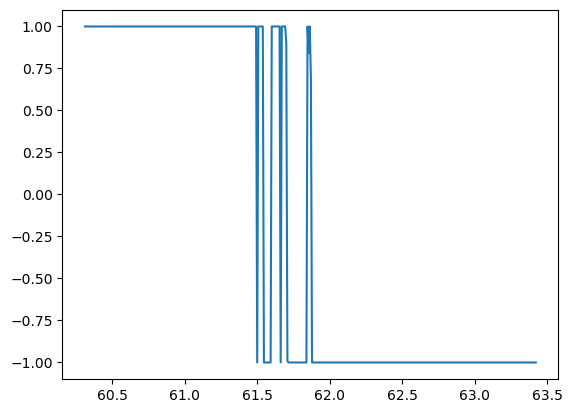

In [20]:
M_obs = get_magnetisation(depth_obs,params)
#M = get_magnetisation(depth,8.9,1.8,5.6,7.2)
plt.plot(depth,M_obs)

In [19]:
M_obs.shape

(200,)

In [30]:
bounds = [(2., 4.),  # a1
          (0.5, 3.),  # a2
          (0, 3.5),    # b1
          (3., 5.)]    # b2

In [31]:
initial_params = [1.0, 1.0, 1.0, 1.0]

In [32]:
solutions = random_restarts_optimization(huber_loss, initial_params, bounds, n_restarts=10)
print("Multiple solutions found:", solutions)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Multiple solutions found: [array([2.28331527, 1.9251672 , 2.12870251, 3.78522706]), array([3.90106346, 2.29382275, 2.63997261, 3.86187346]), array([3.63582666, 2.92339327, 0.94001721, 4.56295163]), array([3.28792104, 1.84629741, 3.42056464, 4.29849376]), array([2.23525743, 1.67149854, 1.39433423, 4.23191403]), array([2.20723393, 1.63575135, 1.33398356, 4.14372182]), array([2.6738604 , 1.96452171, 2.3936971 , 5.        ]), array([2.7116784 , 1.55157217, 2.41770483, 4.12660885]), array([3.52558853, 2.52327682, 1.18265911, 4.44181365]), array([2.53716106, 2.81570985, 1.31322109, 3.96814217])]


In [44]:
get_lock_depth_from_params(solutions[7])

[0.15403922184666033, 1.6291403973000353, 1.370615497304543, 3.948645762126696]

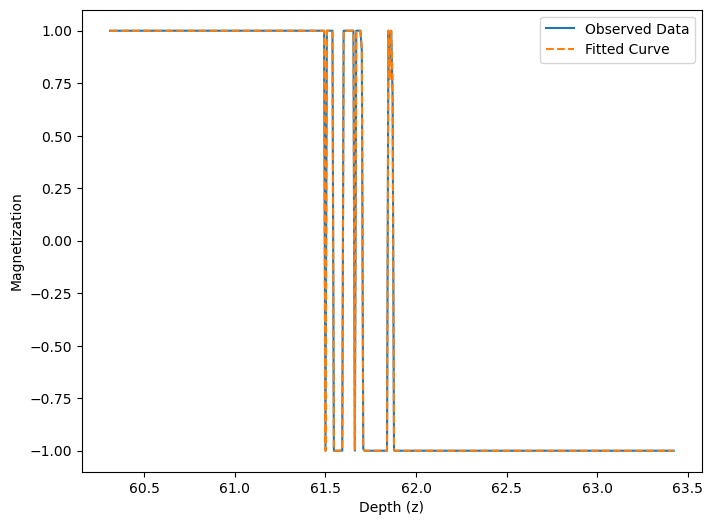

[0.14723921373578114, 1.6432036226707358, 1.5270892614024976, 3.5632082766058275]


In [47]:
ind = 7

M_optimized = get_magnetisation(depth, solutions[ind - 1])

plt.figure(figsize=(8, 6))
plt.plot(depth, M_obs, label='Observed Data')  # Plot the observed data
plt.plot(depth, M_optimized, label='Fitted Curve',linestyle = 'dashed')  # Plot the fitted curve
plt.xlabel('Depth (z)')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

print(get_lock_depth_from_params(solutions[ind - 1]))

In [60]:
result = minimize(huber_loss, initial_params, args=(depth, M_obs), 
                  method='L-BFGS-B', bounds=bounds)

In [66]:
optimized_params = result.x
print('Optimized lock-in-depths:', get_lock_depth_from_params(optimized_params))

Optimized lock-in-depths: [0.0, 1.2641543106855657, 0.6754703792335452, 3.3773518961677262]


In [62]:
M_optimized = get_magnetisation(depth, optimized_params)

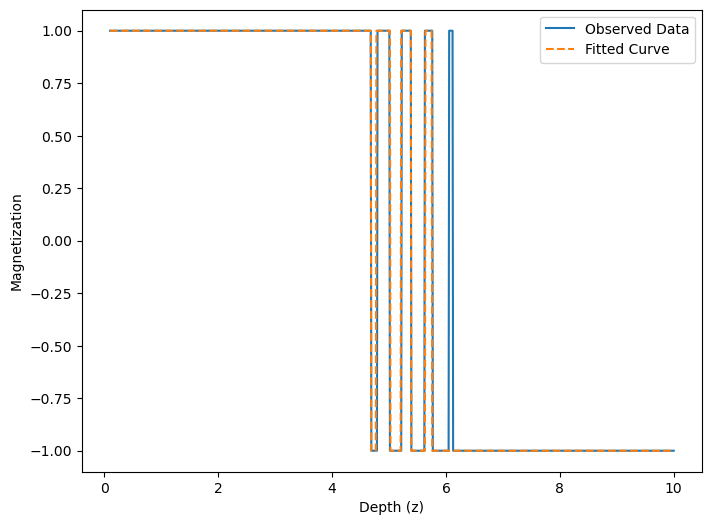

In [63]:
plt.figure(figsize=(8, 6))
plt.plot(depth, M_obs, label='Observed Data')  # Plot the observed data
plt.plot(depth, M_optimized, label='Fitted Curve',linestyle = 'dashed')  # Plot the fitted curve
plt.xlabel('Depth (z)')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

In [90]:
result = minimize(huber_loss, initial_params, args=(depth, M_obs), 
                  method='SLSQP', bounds=bounds)

KeyboardInterrupt: 

In [ ]:
optimized_params = result.x
print('Optimized lock-in-depths:', get_lock_depth_from_params(optimized_params))

In [ ]:
M_optimized = get_magnetisation(depth, optimized_params)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(depth, M_obs, label='Observed Data')  # Plot the observed data
plt.plot(depth, M_optimized, label='Fitted Curve',linestyle = 'dashed')  # Plot the fitted curve
plt.xlabel('Depth (z)')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

In [84]:
result = dual_annealing(huber_loss, bounds, args=(depth, M_obs))

KeyboardInterrupt: 

In [ ]:
optimized_params = result.x
print('Optimized lock-in-depths:', get_lock_depth_from_params(optimized_params))

In [ ]:
M_optimized = get_magnetisation(depth, optimized_params)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(depth, M_obs, label='Observed Data')  # Plot the observed data
plt.plot(depth, M_optimized, label='Fitted Curve',linestyle = 'dashed')  # Plot the fitted curve
plt.xlabel('Depth (z)')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

In [89]:
result = differential_evolution(huber_loss, bounds, args=(depth, M_obs))

KeyboardInterrupt: 

In [ ]:
optimized_params = result.x
print('Optimized lock-in-depths:', get_lock_depth_from_params(optimized_params))

In [ ]:
M_optimized = get_magnetisation(depth, optimized_params)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(depth, M_obs, label='Observed Data')  # Plot the observed data
plt.plot(depth, M_optimized, label='Fitted Curve',linestyle = 'dashed')  # Plot the fitted curve
plt.xlabel('Depth (z)')
plt.ylabel('Magnetization')
plt.legend()
plt.show()